# Interactive AMR Testing Notebook

**Purpose:** Manual exploration and debugging of the DRL-AMR environment.

This notebook provides an interactive widget interface to:
- Select individual mesh elements
- Apply refinement/coarsening actions manually
- Observe reward calculations and solution changes
- Advance the physical simulation timestep-by-step

**Usage:**
1. Run all cells
2. Use the Element slider to select an element
3. Choose an action (Refine/No Change/Coarsen)
4. Click "Apply Action" to execute and see results

**Note:** This is a debugging/exploration tool, not part of the production workflow.

In [1]:
"""
Cell 1: Imports and Configuration
Sets up the environment, imports required modules, and configures matplotlib for SVG output.
"""
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from IPython.display import clear_output
from IPython.display import display as ipython_display

# Configure matplotlib for SVG output
matplotlib.rcParams['savefig.format'] = 'svg'
matplotlib.rcParams['svg.fonttype'] = 'none'  # Keep fonts as text (not paths)
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['savefig.transparent'] = False

# Add project root to path for imports
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

# Project imports
# from numerical.solvers.dg_wave_solver_mixed_clean import DGWaveSolverMixed
from numerical.solvers.dg_advection_solver import DGAdvectionSolver
# from numerical.environments.dg_amr_env_mixed import DGAMREnv, RewardCalculator
from numerical.environments.dg_amr_env import DGAMREnv, RewardCalculator

# Action name mapping for display
ACTION_NAMES = {-1: "Coarsen", 0: "No Change", 1: "Refine"}

In [2]:
"""
Cell 2: InteractiveAMRTester Class Definition

This cell defines the InteractiveAMRTester class, which provides an interactive
widget-based interface for manually testing and visualizing Adaptive Mesh 
Refinement (AMR) actions on the DG advection solver.

Purpose:
    The tester allows researchers to manually explore the AMR environment's
    behavior before training RL agents. It provides immediate visual feedback
    for each refinement/coarsening action, helping to understand:
    - How the reward function responds to different actions
    - How solution quality changes with mesh adaptation
    - The relationship between resource usage and the barrier function
    - Element-level effects of refinement and coarsening

Features:
    - Select individual mesh elements by index and apply actions (refine/coarsen/no-change)
    - Real-time visualization of mesh state, solution, and element refinement levels
    - Track complete action history with reward breakdown (accuracy vs penalty terms)
    - Monitor resource usage with barrier function visualization
    - Advance the physical simulation by timesteps to see wave propagation
    - Adjust environment parameters (budget, gamma_c, epsilon) without restarting kernel

Widget Architecture:
    The interface consists of three main components:
    1. Control widgets (sliders, buttons) for user interaction
    2. Matplotlib figure with 5 subplots showing mesh/solution/history
    3. Console output area for detailed status messages

    Layout (from render()):
    +--------------------------------------------------+
    |              Mesh State (element levels)          |  <- gs[0, :]
    +--------------------------------------------------+
    |              Solution Plot (current + previous)   |  <- gs[1, :]
    +--------------------------------------------------+
    | Action History | Reward History | Resource Usage  |  <- gs[2, 0:2]
    +--------------------------------------------------+
    |              Control Widgets                      |
    +--------------------------------------------------+
    |              Console Output Area                  |
    +--------------------------------------------------+

Dependencies (from Cell 1):
    - numpy as np
    - matplotlib.pyplot as plt
    - matplotlib.patches as patches
    - matplotlib.gridspec as gridspec
    - ipywidgets as widgets
    - IPython.display.clear_output
    - IPython.display.display (imported as ipython_display)
    - DGAdvectionSolver from numerical.solvers.dg_advection_solver
    - DGAMREnv, RewardCalculator from numerical.environments.dg_amr_env
    - ACTION_NAMES dict: {-1: "Coarsen", 0: "No Change", 1: "Refine"}

Data Structure Notes:
    The solver uses 1-indexed element IDs throughout. Key data structures:
    
    - active: Array of currently active element IDs (1-indexed)
      Example: [1, 2, 3, 4] for base mesh, [1, 5, 6, 3, 4] after refining element 2
    
    - label_mat[elem_id-1]: Forest structure for element
      [elem_id, parent_id, child1_id, child2_id, level]
      - parent_id = 0 for base elements
      - child_ids = 0 if element is a leaf (not refined)
      - level = refinement depth (0 = base, 1 = first refinement, etc.)
    
    - info_mat[elem_id-1]: Element geometric info
      [..., x_left, x_right] - last two columns are physical coordinates

Usage:
    See Cell 3 for instantiation example. Typical workflow:
    1. Create tester with desired parameters
    2. Call tester.show_tester() to display interface
    3. Use element slider to select an element
    4. Choose action (Coarsen/No Change/Refine)
    5. Click "Apply Action" to execute and see results
    6. Use "Take Timestep" to advance simulation time
    7. Adjust settings and click "Apply Settings" to experiment with parameters
"""


class InteractiveAMRTester:
    """Interactive widget-based environment for testing AMR actions manually.
    
    Provides a Jupyter notebook interface for exploring the DRL-AMR environment
    without training an RL agent. Users can manually select elements, apply
    refinement/coarsening actions, and observe the effects on:
    - Mesh structure (element boundaries and refinement levels)
    - Solution quality (comparison with previous solution)
    - Reward components (accuracy term vs resource penalty)
    - Resource usage (element count relative to budget)
    
    The tester wraps a DGAMREnv environment and intercepts the element selection
    to allow user control, while still using the environment's step() method
    for action execution and reward computation.
    
    Attributes:
        nop (int): Polynomial order for DG basis functions (degree = nop).
        initial_elements (ndarray): Initial element boundary coordinates defining
            the base mesh before any refinement.
        max_level (int): Maximum allowed refinement level. Elements at this level
            cannot be refined further.
        element_budget (int): Maximum number of active elements allowed. The
            resource usage is computed as n_elements / element_budget.
        gamma_c (float): Scaling factor for the resource penalty term in the
            reward function. Higher values penalize resource usage more.
        machine_eps (float): Small constant added inside log() for numerical
            stability when computing accuracy term.
        accuracy_scaling (float): Multiplier for the accuracy term in reward.
        icase (int): Test case identifier for exact solution:
            1 = Gaussian pulse (always positive)
            10 = Tanh smooth square (has negative values)
            16 = Mexican hat / Ricker wavelet (has negative values)
            See numerical/solvers/utils.py for full list.
        
        solver (DGAdvectionSolver): The underlying DG solver instance that
            performs the actual numerical simulation and mesh operations.
        env (DGAMREnv): The Gymnasium RL environment wrapping the solver.
            Provides step(), reset(), and reward computation.
        reward_calc (RewardCalculator): Separate calculator instance for
            inspecting reward components during debugging.
        
        action_history (list): List of action records, each containing:
            {'action': str, 'element': int (index), 'element_id': int (ID)}
        reward_history (list): List of reward records, each containing:
            {'total': float, 'accuracy': float, 'penalty': float}
        element_history (list): List of element count records:
            {'pre': int, 'post': int, 'delta': int}
        delta_u_history (list): List of solution change magnitudes (floats).
        resource_history (list): List of resource usage records:
            {'pre': float, 'post': float, 'delta': float,
             'old_barrier': float, 'new_barrier': float, 'barrier_delta': float}
        
        auto_save_svg (bool): If True, automatically save figure as SVG after
            each render() call. Disabled by default.
        current_fig (Figure): Reference to current matplotlib figure, used for
            SVG export via save_current_plot_svg().
        
        previous_solution (ndarray): Solution vector before last action, used
            to show dashed reference line in solution plot.
        previous_coord (ndarray): Coordinates before last action.
        previous_resource (float): Resource usage fraction before last action.
        selected_element (int or None): Currently selected element index (1-based).
        selected_action (int or None): Currently selected action (0, 1, or 2).
        
        output_area (widgets.Output): Scrollable text widget for console messages.
        element_slider (widgets.IntSlider): Slider for element selection.
        action_radio (widgets.RadioButtons): Radio buttons for action selection.
        apply_button (widgets.Button): Button to apply selected action.
        reset_button (widgets.Button): Button to reset environment.
        timestep_button (widgets.Button): Button to advance simulation.
        save_button (widgets.Button): Button to save current plot as SVG.
        budget_slider (widgets.IntSlider): Slider to adjust element budget.
        gamma_slider (widgets.FloatSlider): Slider to adjust gamma_c.
        epsilon_slider (widgets.FloatLogSlider): Slider to adjust machine_eps.
        scaling_slider (widgets.FloatSlider): Slider to adjust accuracy_scaling.
        settings_button (widgets.Button): Button to apply new settings.
        auto_save_checkbox (widgets.Checkbox): Checkbox to toggle auto-save.
        control_box (widgets.HBox): Container for all control widgets.
    
    Args:
        nop: Polynomial order for DG basis. Defaults to 4 (quartic polynomials,
            5 LGL points per element).
        initial_elements: Initial element boundary coordinates. Defaults to
            [-1, -0.5, 0, 0.5, 1] which creates 4 base elements on [-1, 1].
        max_level: Maximum refinement level. Defaults to 4.
        element_budget: Maximum allowed elements. Defaults to 25.
        gamma_c: Reward scaling factor for resource penalty. Defaults to 25.0.
        machine_eps: Small constant for numerical stability. Defaults to 1e-16.
        initial_refinement_level: Starting refinement level. Defaults to 1.
            Level 0 = base mesh, level 1 = each base element split once, etc.
        accuracy_scaling: Scaling factor for accuracy term. Defaults to 1.0.
        icase: Test case for exact solution. Defaults to 1 (Gaussian).
    
    Example:
        >>> # Create tester with default Gaussian test case
        >>> tester = InteractiveAMRTester(nop=4, element_budget=25, icase=1)
        >>> tester.show_tester()
        
        >>> # Create tester with Mexican hat waveform
        >>> tester = InteractiveAMRTester(
        ...     nop=4,
        ...     element_budget=30,
        ...     gamma_c=50.0,
        ...     icase=16  # Mexican hat has negative values
        ... )
        >>> tester.show_tester()
    
    Note:
        The element index shown in the UI (and stored in action_history['element'])
        is 1-based for user clarity. Internally, the solver uses 1-indexed element
        IDs stored in the 'active' array. These are different concepts:
        - Element index: position in active array (1 to len(active))
        - Element ID: actual element number in forest (stored in active[index-1])
    """
    
    def __init__(self, 
                 nop=4, 
                 initial_elements=np.array([-1, -0.5, 0, 0.5, 1]), 
                 max_level=4,
                 element_budget=25,
                 gamma_c=25.0,
                 machine_eps=1e-16,
                 initial_refinement_level=1,
                 accuracy_scaling=1.0,
                 icase=1):
        """Initialize the interactive tester with solver and environment.
        
        Initialization performs the following steps:
        1. Store all configuration parameters as instance attributes
        2. Create solver and environment via create_environment()
        3. Initialize empty history lists for tracking actions/rewards/resources
        4. Create a RewardCalculator for manual reward inspection
        5. Set up all interactive widgets via setup_widgets()
        6. Initialize console output area with welcome message
        
        Args:
            nop: Polynomial order (degree of basis polynomials).
            initial_elements: Array of element boundary x-coordinates.
            max_level: Maximum allowed refinement level.
            element_budget: Maximum number of elements (for resource calculation).
            gamma_c: Scaling factor for resource penalty in reward.
            machine_eps: Small constant for log stability.
            initial_refinement_level: How many times to uniformly refine at start.
            accuracy_scaling: Multiplier for accuracy term in reward.
            icase: Test case number for initial condition / exact solution.
        """
        # =====================================================================
        # Store configuration parameters as instance attributes
        # These define the problem setup and are used throughout the class
        # for environment creation, rendering, and parameter display
        # =====================================================================
        self.nop = nop
        self.initial_elements = initial_elements
        self.max_level = max_level
        self.element_budget = element_budget
        self.gamma_c = gamma_c
        self.machine_eps = machine_eps
        self.accuracy_scaling = accuracy_scaling
        self.icase = icase
        
        # =====================================================================
        # Create the DG solver and RL environment
        # This sets up:
        # - self.solver: DGAdvectionSolver instance
        # - self.env: DGAMREnv wrapping the solver
        # - self.obs, self.info: Initial observation and info from reset
        # - self.previous_solution, self.previous_resource: Initial state
        # - self.selected_element, self.selected_action: Set to None
        # =====================================================================
        self.create_environment(initial_refinement_level)
        
        # =====================================================================
        # Initialize history tracking lists
        # These accumulate data as the user takes actions, enabling
        # visualization of trends and debugging of reward behavior
        # =====================================================================
        self.action_history = []      # List of {action, element, element_id} dicts
        self.reward_history = []      # List of {total, accuracy, penalty} dicts
        self.element_history = []     # List of {pre, post, delta} element counts
        self.delta_u_history = []     # List of solution change magnitudes (floats)
        self.resource_history = []    # List of {pre, post, delta, barriers} dicts
        
        # =====================================================================
        # Create separate reward calculator for inspection/debugging
        # This mirrors the environment's internal calculator, allowing
        # manual computation and verification of reward components
        # =====================================================================
        self.reward_calc = RewardCalculator(gamma_c=gamma_c)
        self.reward_calc.machine_eps = machine_eps

        # =====================================================================
        # Auto-save SVG flag
        # When enabled, the render() method automatically exports the current
        # figure as an SVG file after each update. Useful for creating
        # presentation materials but disabled by default to avoid clutter.
        # =====================================================================
        self.auto_save_svg = False

        # =====================================================================
        # Create console output widget
        # This provides a scrollable text area within the notebook for:
        # - Action result summaries
        # - Reward component breakdowns
        # - Debug information
        # - Status messages
        # Using widgets.Output captures print() calls within its context
        # =====================================================================
        self.output_area = widgets.Output(
            layout={
                'border': '1px solid #ccc',      # Visible border
                'padding': '10px',                # Inner spacing
                'height': '300px',                # Fixed height for scrolling
                'overflow_y': 'auto',             # Enable vertical scrollbar
                'font-family': 'monospace',       # Fixed-width for alignment
                'background-color': '#f9f9f9',   # Light gray background
                'margin-top': '20px'              # Space above widget
            }
        )
        
        # =====================================================================
        # Create interactive control widgets
        # This populates all slider, button, and checkbox attributes
        # and arranges them into layout containers
        # =====================================================================
        self.setup_widgets()
        
        # =====================================================================
        # Initialize console with welcome message
        # The 'with' context ensures output appears in the widget area
        # =====================================================================
        with self.output_area:
            print("=== AMR Testing Console Output ===")
            print(f"Initial state: {len(self.env.solver.active)}/{self.element_budget} elements")
            print("Use the controls to select elements and apply actions.\n")

    def console_print(self, *args, **kwargs):
        """Print to the notebook output widget instead of standard console.
        
        Redirects print output to the scrollable output_area widget,
        keeping all status messages contained within the notebook interface
        rather than appearing in separate cell output.
        
        Args:
            *args: Positional arguments passed directly to print().
            **kwargs: Keyword arguments passed directly to print().
        
        Example:
            >>> self.console_print(f"Action result: {reward:.4f}")
            >>> self.console_print("Elements:", pre, "->", post)
        """
        with self.output_area:
            print(*args, **kwargs)

        
    def save_current_plot_svg(self, filename=None):
        """Save the current figure as SVG vector graphics.
        
        Exports the matplotlib figure stored in self.current_fig to an SVG file.
        SVG format preserves vector quality for publication and presentations.
        
        The matplotlib SVG settings (configured in Cell 1) ensure:
        - Fonts are kept as text (not converted to paths)
        - Tight bounding box with minimal whitespace
        - Opaque background
        
        Args:
            filename: Output filename string. If None, generates a timestamped
                name like 'amr_plot_1737654321.svg' using Unix timestamp.
                
        Returns:
            str: The filename if save was successful.
            None: If no figure is available (self.current_fig is None).
        
        Example:
            >>> self.save_current_plot_svg()  # Auto-named
            Saved as amr_plot_1737654321.svg
            
            >>> self.save_current_plot_svg("my_mesh_state.svg")
            Saved as my_mesh_state.svg
        """
        import time
        
        # Generate default filename with Unix timestamp if not provided
        # This ensures unique filenames for sequential saves
        if filename is None:
            filename = f'amr_plot_{int(time.time())}.svg'
        
        # Check if we have a figure to save
        if hasattr(self, 'current_fig') and self.current_fig is not None:
            self.current_fig.savefig(filename, format='svg', bbox_inches='tight')
            self.console_print(f"Saved as {filename}")
            return filename
        else:
            self.console_print("No current figure available to save")
            return None


    def debug_data_structures(self):
        """Print debug information about solver internal data structures.
        
        Utility method for inspecting the solver's mesh representation.
        Useful when debugging issues with element indexing, coordinates,
        or forest hierarchy.
        
        Prints to console:
            - xelem: Element boundary coordinates array
            - active: Currently active element IDs
            - label_mat: Forest structure (parent/child/level info)
            - info_mat: Element geometric info (coordinates)
        
        Note:
            Elements are 1-indexed in the solver. To access data for
            element ID 'elem', use label_mat[elem-1] and info_mat[elem-1].
        """
        self.console_print("\nDebugging Data Structures:")
        
        # Element boundary coordinates (defines physical mesh)
        self.console_print(f"xelem: shape={np.shape(self.env.solver.xelem)}")
        self.console_print(f"xelem first few elements: {self.env.solver.xelem[:5]}")
        
        # Active element IDs (1-indexed integers)
        self.console_print(f"active elements: count={len(self.env.solver.active)}")
        self.console_print(f"active first few elements: {self.env.solver.active[:5]}")
        
        # Forest structure: label_mat[elem-1] = [id, parent, child1, child2, level]
        self.console_print(f"label_mat: shape={np.shape(self.env.solver.label_mat)}")
        if len(self.env.solver.active) > 0:
            first_elem = self.env.solver.active[0]
            self.console_print(f"label_mat for first element: {self.env.solver.label_mat[first_elem-1]}")
        
        # Element info: info_mat[elem-1] = [..., x_left, x_right]
        self.console_print(f"info_mat: shape={np.shape(self.env.solver.info_mat)}")
        if len(self.env.solver.active) > 0:
            first_elem = self.env.solver.active[0]
            self.console_print(f"info_mat for first element: {self.env.solver.info_mat[first_elem-1]}")

    def create_environment(self, initial_refinement_level):
        """Create the DG solver and RL environment objects.
        
        Instantiates a DGAdvectionSolver with the configured parameters,
        wraps it in a DGAMREnv for RL-style interaction, and performs
        the initial reset with uniform refinement.
        
        The solver is created with max_elements = element_budget * 2 to
        provide headroom for temporary over-budget states during exploration.
        
        Args:
            initial_refinement_level: Number of uniform refinement passes to apply.
                Level 0 keeps the base mesh (len(initial_elements)-1 elements).
                Level 1 doubles the element count (each base element split once).
                Level 2 quadruples the element count, etc.
        
        Side Effects:
            Sets the following instance attributes:
            - self.solver: DGAdvectionSolver instance
            - self.env: DGAMREnv wrapping the solver
            - self.obs: Initial observation dict from env.reset()
            - self.info: Initial info dict from env.reset()
            - self.previous_solution: Copy of initial solution vector
            - self.previous_resource: Initial resource usage fraction
            - self.selected_element: Set to None
            - self.selected_action: Set to None
        """
        # =====================================================================
        # Create the Discontinuous Galerkin advection solver
        # This handles all numerical computation and mesh operations
        # =====================================================================
        self.solver = DGAdvectionSolver(
            nop=self.nop,                           # Polynomial order
            xelem=self.initial_elements,            # Base mesh boundaries
            max_elements=self.element_budget * 2,   # Allow headroom above budget
            max_level=self.max_level,               # Refinement limit
            courant_max=0.1,                        # CFL number for stability
            icase=self.icase,                       # Test case (IC + exact soln)
            verbose=True,                           # Print solver status
            balance=False                           # Disable 2:1 balance for simplicity
        )
        
        # =====================================================================
        # Create the RL environment wrapping the solver
        # This provides the Gymnasium interface (obs/action/reward/step/reset)
        # =====================================================================
        self.env = DGAMREnv(
            solver=self.solver,
            element_budget=self.element_budget,
            gamma_c=self.gamma_c,
            max_episode_steps=100,                  # Episode length limit
            verbose=True,                           # Print environment status
            rl_iterations_per_timestep=100,         # Actions before timestep
            max_rl_iterations=5,                    # Unused in this context
            debug_training_cycle=True               # Enable detailed debugging
        )
        
        # =====================================================================
        # Reset environment with specified initial refinement
        # 'fixed' mode applies uniform refinement to all elements
        # =====================================================================
        self.obs, self.info = self.env.reset(options={
            'refinement_mode': 'fixed',
            'refinement_level': initial_refinement_level
        })
        
        # =====================================================================
        # Store initial state for comparison after first action
        # previous_solution: shown as dashed line in solution plot
        # previous_resource: used to compute barrier function change
        # =====================================================================
        self.previous_solution = self.env.solver.q.copy()
        self.previous_resource = len(self.env.solver.active) / self.element_budget
        self.selected_element = None
        self.selected_action = None
            
        
    def setup_widgets(self):
        """Create and configure all interactive control widgets.
        
        Sets up ipywidgets for user interaction:
        
        Element/Action Selection:
            - element_slider: IntSlider for selecting element by index (1-based)
            - action_radio: RadioButtons for Coarsen/No Change/Refine
        
        Action Buttons:
            - apply_button: Execute selected action on selected element
            - reset_button: Reset environment to initial state
            - timestep_button: Advance physical simulation by one timestep
            - save_button: Export current figure as SVG
        
        Settings Sliders:
            - budget_slider: Adjust element_budget (5-50)
            - gamma_slider: Adjust gamma_c (1-100)
            - epsilon_slider: Adjust machine_eps (10^-16 to 10^-4, log scale)
            - scaling_slider: Adjust accuracy_scaling (0.01-2.0)
            - settings_button: Apply new settings (recreates environment)
        
        Toggle:
            - auto_save_checkbox: Enable/disable automatic SVG export
        
        Layout Containers:
            - element_action_box: VBox with element slider, action radio, apply button
            - settings_box: VBox with all settings sliders
            - control_box: HBox combining all widget groups horizontally
        
        Side Effects:
            Sets all widget attributes listed above.
            Registers callback functions for button clicks and checkbox changes.
        """
        
        # =====================================================================
        # Element and Action Selection Widgets
        # =====================================================================
        
        # IntSlider for selecting which element to act on
        # Range: 1 to number of active elements (1-based for user clarity)
        # continuous_update=False: only trigger callback on mouse release
        self.element_slider = widgets.IntSlider(
            min=1,
            max=len(self.env.solver.active),
            step=1,
            description='Element:',
            continuous_update=False
        )
        
        # RadioButtons for action selection
        # Display text maps to internal action codes:
        # 'Coarsen' -> 0 (maps to -1 via action_mapping)
        # 'No Change' -> 1 (maps to 0)
        # 'Refine' -> 2 (maps to +1)
        self.action_radio = widgets.RadioButtons(
            options=[('Coarsen', 0), ('No Change', 1), ('Refine', 2)],
            description='Action:',
            disabled=False
        )
        
        # =====================================================================
        # Action Buttons
        # Each button has a callback registered via on_click()
        # =====================================================================
        
        # Apply button: execute the currently selected action
        self.apply_button = widgets.Button(
            description='Apply Action',
            button_style='success',   # Green background
            tooltip='Apply the selected action to the selected element'
        )
        self.apply_button.on_click(self.on_apply_action)
        
        # Reset button: restore environment to initial state
        self.reset_button = widgets.Button(
            description='Reset Environment',
            button_style='warning',   # Yellow/orange background
            tooltip='Reset the environment to initial state'
        )
        self.reset_button.on_click(self.on_reset)
        
        # Timestep button: advance physical simulation
        self.timestep_button = widgets.Button(
            description='Take Timestep',
            button_style='primary',   # Blue background
            tooltip='Advance the physical simulation one timestep'
        )
        self.timestep_button.on_click(self.on_take_timestep)
        
        # Save SVG button: export current visualization
        self.save_button = widgets.Button(
            description='Save SVG',
            button_style='',          # Default gray background
            tooltip='Save current plot as SVG file'
        )
        # Lambda wrapper needed because on_click passes button as argument
        self.save_button.on_click(lambda b: self.save_current_plot_svg())
        
        # =====================================================================
        # Environment Settings Widgets
        # Allow changing parameters without restarting the notebook
        # =====================================================================
        
        # Element budget slider
        # Controls the maximum number of elements allowed
        # Used in resource calculation: resource = n_elements / element_budget
        self.budget_slider = widgets.IntSlider(
            min=5, max=50, step=5,
            value=self.element_budget,
            description='Budget:',
            continuous_update=False
        )
        
        # Gamma_c slider
        # Controls scaling of resource penalty term in reward function
        # Higher gamma_c = stronger penalty for using more elements
        self.gamma_slider = widgets.FloatSlider(
            min=1.0, max=100.0, step=1.0,
            value=self.gamma_c,
            description='Gamma_c:',
            continuous_update=False
        )
        
        # Machine epsilon slider (logarithmic scale)
        # Small constant added in log(delta_u + epsilon) for stability
        # Range: 10^-16 to 10^-4
        self.epsilon_slider = widgets.FloatLogSlider(
            base=10,
            min=-16, max=-4, step=1,
            value=self.machine_eps,
            description='Machine ε:',
            continuous_update=False
        )
        
        # Accuracy scaling slider
        # Multiplier for the accuracy (solution improvement) term in reward
        self.scaling_slider = widgets.FloatSlider(
            min=0.01, max=2.0, step=0.01,
            value=self.accuracy_scaling,
            description='Acc. Scale:',
            continuous_update=False
        )
        
        # Apply settings button
        # Recreates the entire environment with new parameter values
        self.settings_button = widgets.Button(
            description='Apply Settings',
            button_style='info',      # Light blue background
            tooltip='Apply new environment settings (resets environment)'
        )
        self.settings_button.on_click(self.on_apply_settings)
        
        # =====================================================================
        # Auto-save SVG Checkbox
        # =====================================================================
        self.auto_save_checkbox = widgets.Checkbox(
            value=self.auto_save_svg,
            description='Auto-save SVG',
            tooltip='Automatically save SVG after each action'
        )
        # observe() watches for value changes (different from on_click)
        self.auto_save_checkbox.observe(self.on_auto_save_changed, names='value')
        
        # =====================================================================
        # Layout Arrangement
        # Organize widgets into logical groups using VBox (vertical) and HBox (horizontal)
        # =====================================================================
        
        # Left column: element selection and action controls
        self.element_action_box = widgets.VBox([
            self.element_slider,
            self.action_radio,
            self.apply_button
        ])
        
        # Right column: environment parameter settings
        self.settings_box = widgets.VBox([
            self.budget_slider,
            self.gamma_slider,
            self.epsilon_slider,
            self.scaling_slider,
            self.settings_button
        ])
        
        # Main control box: all widget groups arranged horizontally
        # Middle column has simulation control buttons
        self.control_box = widgets.HBox([
            self.element_action_box,
            widgets.VBox([self.reset_button, self.timestep_button, self.save_button, self.auto_save_checkbox]),
            self.settings_box
        ])

    def on_auto_save_changed(self, change):
        """Callback when auto-save checkbox is toggled.
        
        Updates the auto_save_svg flag based on checkbox state and
        prints confirmation to console.
        
        Args:
            change: ipywidgets change dictionary containing:
                - 'new': The new checkbox value (True/False)
                - 'old': The previous value
                - 'owner': The checkbox widget
                - 'name': The property that changed ('value')
        """
        self.auto_save_svg = change['new']
        self.console_print(f"Auto-save SVG: {'enabled' if self.auto_save_svg else 'disabled'}")
        

    def on_apply_action(self, b):
        """Callback for the Apply Action button click.
        
        This is the main action execution handler. It performs:
        
        1. State Capture (Pre-Action):
           - Read selected element index and action from widgets
           - Record element count and resource usage
           - Convert element index to element ID
        
        2. Solution Backup:
           - Copy current solution and coordinates for visualization
           - These become the "previous" reference in plots
        
        3. Action Execution:
           - Temporarily set env.current_element_index to user selection
           - Call env.step() with the selected action
           - Restore original element index
        
        4. State Analysis (Post-Action):
           - Compute element count change
           - Extract delta_u from step info
           - Calculate barrier function values before/after
        
        5. History Update:
           - Append to all history lists (action, reward, resource, etc.)
        
        6. Console Output:
           - Print detailed summary of action results
        
        7. Visualization Update:
           - Call render() to refresh all plots
           - Update element slider range if needed
           - Warn if action was limited by refinement constraints
        
        Args:
            b: The button widget that triggered the callback.
                Required by ipywidgets but not used in this method.
        
        Note:
            The action_radio widget uses values 0, 1, 2 which map to
            actual actions -1, 0, +1 via env.action_mapping.
        """
        # =====================================================================
        # Read user selections from widgets
        # =====================================================================
        self.selected_element = self.element_slider.value    # 1-based index
        self.selected_action = self.action_radio.value       # 0, 1, or 2
        
        # =====================================================================
        # Capture pre-action state for comparison and history
        # =====================================================================
        pre_elements = len(self.env.solver.active)
        pre_resource = pre_elements / self.element_budget
        
        # =====================================================================
        # Convert element index (1-based UI) to element ID (solver internal)
        # Element index is position in active array
        # Element ID is the actual element number in the forest
        # =====================================================================
        if self.selected_element <= len(self.env.solver.active):
            element_id = self.env.solver.active[self.selected_element - 1]
        else:
            print(f"Error: Selected element {self.selected_element} out of range")
            return
        
        # =====================================================================
        # Get the mapped action value from environment's mapping
        # action_mapping: {0: -1 (coarsen), 1: 0 (no change), 2: +1 (refine)}
        # =====================================================================
        mapped_action = self.env.action_mapping[self.selected_action]
        
        # =====================================================================
        # Store current solution for "previous" reference in visualization
        # These will be shown as dashed lines after the action
        # =====================================================================
        self.previous_solution = self.env.solver.q.copy()
        self.previous_coord = self.env.solver.coord.copy()
        self.previous_resources = pre_resource
        
        # =====================================================================
        # Print action being taken
        # ACTION_NAMES is defined in Cell 1: {-1: "Coarsen", 0: "No Change", 1: "Refine"}
        # =====================================================================
        self.console_print(f"\nApplying {ACTION_NAMES[mapped_action]} to element {self.selected_element} (ID: {element_id})")
        
        # =====================================================================
        # Override environment's element index to apply action to user's selection
        # The environment normally cycles through elements during training;
        # we want to target a specific user-selected element
        # =====================================================================
        original_element_index = self.env.current_element_index
        
        # Set environment to act on our selected element (convert to 0-based)
        self.env.current_element_index = self.selected_element - 1
        
        # =====================================================================
        # Execute the action through the standard environment step method
        # This handles:
        # - Action validation (can this element be refined/coarsened?)
        # - Mesh modification (actual refinement/coarsening)
        # - Solution projection (transfer solution to new mesh)
        # - Reward computation
        # =====================================================================
        obs, reward, terminated, truncated, info = self.env.step(self.selected_action)
        
        # Restore original element index after our action
        self.env.current_element_index = original_element_index
        
        # =====================================================================
        # Capture post-action state
        # =====================================================================
        post_elements = len(self.env.solver.active)
        post_resource = post_elements / self.element_budget
        delta_elements = post_elements - pre_elements
        
        # =====================================================================
        # Get solution change magnitude from info dict
        # delta_u measures how much the solution changed due to projection
        # =====================================================================
        if 'delta_u' in info:
            delta_u = info['delta_u']
        else:
            delta_u = 0.0
        
        # =====================================================================
        # Calculate barrier function values for reward analysis
        # Barrier function: B(p) = sqrt(p) / (1 - p)
        # This function increases sharply as p approaches 1 (budget limit)
        # The change in barrier (new - old) is the resource penalty component
        # =====================================================================
        def calculate_barrier(p):
            if p >= 1.0:
                return float('inf')  # At or over budget: infinite penalty
            elif p <= 0.0:
                return 0.0           # No resources used: no penalty
            else:
                return np.sqrt(p) / (1 - p)
                
        old_barrier = calculate_barrier(pre_resource)
        new_barrier = calculate_barrier(post_resource)
        barrier_delta = new_barrier - old_barrier
        
        # =====================================================================
        # Update all history lists
        # Store both element index (UI position) and element ID (forest ID)
        # =====================================================================
        self.action_history.append({
            'action': ACTION_NAMES[mapped_action], 
            'element': self.selected_element,
            'element_id': element_id
        })
        
        self.reward_history.append({
            'total': reward, 
            'accuracy': info.get('accuracy_term', 0.0), 
            'penalty': info.get('resource_penalty', 0.0)
        })
        
        self.resource_history.append({
            'pre': pre_resource,
            'post': post_resource,
            'delta': post_resource - pre_resource,
            'old_barrier': old_barrier,
            'new_barrier': new_barrier,
            'barrier_delta': barrier_delta
        })
        
        self.element_history.append({
            'pre': pre_elements,
            'post': post_elements,
            'delta': delta_elements
        })
        
        self.delta_u_history.append(delta_u)
        
        # =====================================================================
        # Print detailed action results to console widget
        # =====================================================================
        self.console_print(f"Action result:")
        self.console_print(f"  Reward: {reward:.4f}")
        self.console_print(f"  Δu (solution change): {delta_u:.6e}")
        self.console_print(f"  Elements: {pre_elements} → {post_elements} (Δ{delta_elements:+d})")
        self.console_print(f"  Resource usage: {pre_resource*100:.1f}% → {post_resource*100:.1f}%")
        self.console_print(f"  Barrier function: {old_barrier:.4f} → {new_barrier:.4f} (Δ{barrier_delta:+.4f})")

        # =====================================================================
        # Update visualization with new state
        # =====================================================================
        self.render()

        # =====================================================================
        # Update element slider range if element count changed
        # Refinement increases count, coarsening decreases it
        # =====================================================================
        current_element_count = len(self.env.solver.active)
        self.element_slider.max = current_element_count
        
        # If current selection is now out of range, move to middle of new range
        if self.selected_element > current_element_count:
            self.element_slider.value = current_element_count // 2
        
        # Update slider label to show new range
        self.element_slider.description = f'Element (1-{current_element_count}):'
        
        # =====================================================================
        # Notify user if action was constrained by refinement level limits
        # =====================================================================
        element_level = info.get('element_level', -1)
        if mapped_action == 1 and element_level == self.env.solver.max_level:
            # Tried to refine but element is already at max level
            self.console_print(f"Note: Element {element_id} already at maximum refinement level ({self.env.solver.max_level})")
            print(f"Note: Element {element_id} already at maximum refinement level ({self.env.solver.max_level})")
        elif mapped_action == -1 and element_level == 0:
            # Tried to coarsen but element is already at base level
            self.console_print(f"Note: Element {element_id} already at base level (0)")
            print(f"Note: Element {element_id} already at base level (0)")    
   

    
    
    def on_reset(self, b):
        """Callback for the Reset Environment button click.
        
        Resets the environment to its initial state, clearing all history
        and restoring the mesh to its starting configuration.
        
        The reset preserves approximate mesh density by estimating the
        current refinement level from element count.
        
        Args:
            b: The button widget that triggered the callback.
                Required by ipywidgets but not used in this method.
        
        Side Effects:
            - Resets environment via env.reset()
            - Clears all history lists
            - Resets slider range and value
            - Updates visualization
        """
        # =====================================================================
        # Estimate current refinement level from element count
        # Formula: n_elements = n_base * 2^level, so level = log2(n_elem / n_base)
        # n_base = len(initial_elements) - 1 (number of intervals)
        # =====================================================================
        initial_refinement = int(np.log2(len(self.env.solver.active) / (len(self.initial_elements) - 1)))
        initial_refinement = max(1, min(initial_refinement, self.max_level))
        
        self.console_print(f"Resetting environment with refinement level {initial_refinement}...")
        
        # =====================================================================
        # Reset the environment with fixed uniform refinement
        # =====================================================================
        self.obs, self.info = self.env.reset(options={
            'refinement_mode': 'fixed',
            'refinement_level': initial_refinement
        })
        
        # =====================================================================
        # Clear all history lists to start fresh
        # =====================================================================
        self.action_history = []
        self.reward_history = []
        self.element_history = []
        self.delta_u_history = []
        self.resource_history = []
        
        # =====================================================================
        # Store fresh initial state
        # =====================================================================
        self.previous_solution = self.env.solver.q.copy()
        self.previous_coord = self.env.solver.coord.copy()
        self.previous_resource = len(self.env.solver.active) / self.element_budget
        self.selected_element = None
        self.selected_action = None
        
        # =====================================================================
        # Update slider to new element count
        # =====================================================================
        self.element_slider.max = len(self.env.solver.active)
        self.element_slider.value = 1
        
        # =====================================================================
        # Render the reset state
        # =====================================================================
        self.render()
        self.console_print("Environment reset complete.")   
    

    def on_apply_settings(self, b):
        """Callback for the Apply Settings button click.
        
        Reads new parameter values from the settings widgets and
        recreates the entire environment with these values. This
        effectively performs a reset with new configuration.
        
        Args:
            b: The button widget that triggered the callback.
                Required by ipywidgets but not used in this method.
        
        Side Effects:
            - Updates instance parameter attributes
            - Recreates solver and environment via create_environment()
            - Creates new reward calculator
            - Clears all history lists
            - Updates visualization
        """
        # =====================================================================
        # Read new parameter values from widgets
        # =====================================================================
        new_budget = self.budget_slider.value
        new_gamma = self.gamma_slider.value
        new_epsilon = self.epsilon_slider.value
        new_scaling = self.scaling_slider.value
        
        self.console_print(f"Applying new settings: Budget={new_budget}, Gamma={new_gamma}, Epsilon={new_epsilon:.1e}, Scaling={new_scaling}")
        
        # =====================================================================
        # Update instance attributes with new values
        # =====================================================================
        self.element_budget = new_budget
        self.gamma_c = new_gamma
        self.machine_eps = new_epsilon
        self.accuracy_scaling = new_scaling
        
        # =====================================================================
        # Estimate current refinement level to preserve approximate mesh density
        # =====================================================================
        current_active = len(self.env.solver.active)
        current_refinement = int(np.log2(current_active / (len(self.initial_elements) - 1)))
        current_refinement = max(1, min(current_refinement, self.max_level))
        
        # =====================================================================
        # Recreate environment with new settings
        # This creates new solver and env instances with updated parameters
        # =====================================================================
        self.create_environment(current_refinement)
        
        # =====================================================================
        # Update reward calculator with new parameters
        # =====================================================================
        self.reward_calc = RewardCalculator(gamma_c=new_gamma)
        self.reward_calc.machine_eps = new_epsilon
        
        # =====================================================================
        # Clear history since this is essentially a new environment
        # =====================================================================
        self.action_history = []
        self.reward_history = []
        self.element_history = []
        self.delta_u_history = []
        self.resource_history = []
        
        # =====================================================================
        # Update slider to new element count
        # =====================================================================
        self.element_slider.max = len(self.env.solver.active)
        self.element_slider.value = 1
        
        # =====================================================================
        # Render with new settings
        # =====================================================================
        self.render()
        self.console_print("New settings applied successfully.")
        
    def on_take_timestep(self, b):
        """Callback for the Take Timestep button click.
        
        Advances the physical simulation by one timestep, propagating
        the wave solution forward in time. This is useful for observing
        how the mesh adaptation should track a moving wave.
        
        Implementation Note:
            The environment triggers a timestep when current_rl_iteration
            reaches rl_iterations_per_timestep. We exploit this by setting
            the counter to threshold-1, so the next step() triggers a timestep.
        
        Args:
            b: The button widget that triggered the callback.
                Required by ipywidgets but not used in this method.
        
        Side Effects:
            - Advances simulation time in solver
            - Updates solution vector
            - Adds "Timestep" entry to action_history
            - Updates visualization
        """
        self.console_print("\nAdvancing physical simulation by one timestep...")
        
        # =====================================================================
        # Capture pre-timestep state
        # =====================================================================
        pre_solution = self.env.solver.q.copy()
        pre_coord = self.env.solver.coord.copy()
        pre_elements = len(self.env.solver.active)
        pre_resource = pre_elements / self.element_budget
        pre_time = self.env.solver.time
        
        # =====================================================================
        # Trigger timestep by manipulating RL iteration counter
        # When current_rl_iteration reaches rl_iterations_per_timestep,
        # the environment advances the simulation by one physical timestep
        # =====================================================================
        original_iteration = self.env.current_rl_iteration
        self.env.current_rl_iteration = self.env.rl_iterations_per_timestep - 1
        
        # =====================================================================
        # Execute a "no change" action to trigger the timestep logic
        # The actual action doesn't matter; we just need step() to run
        # and detect that it's time for a timestep
        # =====================================================================
        original_element_index = self.env.current_element_index
        self.env.current_element_index = 0  # Act on first element
        obs, reward, terminated, truncated, info = self.env.step(1)  # 1 = No Change
        
        # Restore original element index
        self.env.current_element_index = original_element_index
        
        # =====================================================================
        # Calculate solution change due to wave propagation
        # =====================================================================
        post_solution = self.env.solver.q.copy()
        solution_change = np.linalg.norm(post_solution - pre_solution)
        post_time = self.env.solver.time
        
        # =====================================================================
        # Store pre-timestep solution for visualization
        # =====================================================================
        self.previous_solution = pre_solution
        self.previous_coord = pre_coord
        
        # =====================================================================
        # Update history with timestep entry
        # Use None for values that don't apply to timesteps (not actions)
        # =====================================================================
        self.action_history.append({
            'element': None,
            'element_id': None,
            'action': "Timestep"
        })
        
        self.reward_history.append({
            'total': None,       # No reward for timesteps
            'accuracy': None,
            'penalty': None
        })
        
        self.element_history.append({
            'pre': pre_elements,
            'post': len(self.env.solver.active),
            'delta': len(self.env.solver.active) - pre_elements
        })
        
        self.delta_u_history.append(solution_change)
        
        self.resource_history.append({
            'pre': pre_resource,
            'post': len(self.env.solver.active) / self.element_budget,
            'old_barrier': None,  # Not computed for timesteps
            'new_barrier': None
        })
        
        # =====================================================================
        # Update visualization
        # =====================================================================
        self.render()
        
        # =====================================================================
        # Print timestep summary
        # =====================================================================
        time_delta = post_time - pre_time
        self.console_print(f"Timestep complete.")
        self.console_print(f"  Time: {pre_time:.4f} → {post_time:.4f} (Δt = {time_delta:.4e})")
        self.console_print(f"  Solution change: {solution_change:.6e}")
        self.console_print(f"  Elements: {pre_elements} → {len(self.env.solver.active)}")
        
        # =====================================================================
        # Update slider if element count changed during timestep
        # (This could happen if environment has auto-adaptation)
        # =====================================================================
        if pre_elements != len(self.env.solver.active):
            self.element_slider.max = len(self.env.solver.active)
            self.element_slider.description = f'Element (1-{len(self.env.solver.active)}):'

    def print_action_results(self, action, actual_action, delta_u, accuracy_term,
                                expected_accuracy, pre_resource, post_resource,
                                old_barrier, new_barrier, resource_penalty,
                                expected_reward, actual_reward, pre_elements, post_elements):
        """Print verbose debug output for action results.
        
        This method provides detailed breakdown of all reward computation
        components. It may be called for debugging specific reward issues
        but is not used in the normal action flow (on_apply_action prints
        a simpler summary).
        
        Args:
            action: The requested action string (from ACTION_NAMES).
            actual_action: The action actually taken (may differ if invalid).
            delta_u: Solution change magnitude after action.
            accuracy_term: Computed accuracy component of reward.
            expected_accuracy: Expected accuracy contribution.
            pre_resource: Resource usage fraction before action.
            post_resource: Resource usage fraction after action.
            old_barrier: Barrier function value before action.
            new_barrier: Barrier function value after action.
            resource_penalty: Computed resource penalty component.
            expected_reward: Manually calculated expected total reward.
            actual_reward: Actual reward returned by environment.
            pre_elements: Element count before action.
            post_elements: Element count after action.
        """
        self.console_print("\n=== Action Results ===")
        self.console_print(f"Action: {action} (Actual: {actual_action})")
        self.console_print(f"Elements: {pre_elements} -> {post_elements} (Δ{post_elements-pre_elements})")
        self.console_print(f"Resource: {pre_resource:.4f} -> {post_resource:.4f}")
        self.console_print("\n--- Solution Impact ---")
        self.console_print(f"Delta_u: {delta_u:.6e}")
        self.console_print(f"log(Delta_u): {np.log(abs(delta_u) + self.machine_eps):.4f}")
        self.console_print(f"Accuracy term (unscaled): {accuracy_term/self.accuracy_scaling:.4f}")
        self.console_print(f"Accuracy term (scaled): {accuracy_term:.4f}")
        self.console_print(f"Expected accuracy contribution: {expected_accuracy:.4f}")
        self.console_print("\n--- Resource Impact ---")
        self.console_print(f"Old barrier: {old_barrier:.4f}")
        self.console_print(f"New barrier: {new_barrier:.4f}")
        self.console_print(f"Resource penalty: {resource_penalty:.4f}")
        self.console_print(f"Scaled penalty (gamma_c={self.gamma_c}): {self.gamma_c * resource_penalty:.4f}")
        self.console_print("\n--- Final Reward ---")
        self.console_print(f"Expected reward: {expected_reward:.4f}")
        self.console_print(f"Actual reward: {actual_reward:.4f}")
        self.console_print("=====================\n")

    def render(self):
        """Render the current state with all visualizations.
        
        Creates a matplotlib figure with 5 subplots arranged in a grid:
        
        Row 0 (full width): Mesh State
            - Elements shown as rectangles with height = refinement level
            - Element IDs labeled above each element
            - Selected/affected elements highlighted in orange
        
        Row 1 (full width): Solution Plot
            - Current solution as solid blue line
            - Previous solution as dashed magenta line
            - Element boundaries as gray dashed lines
            - Affected regions shaded
        
        Row 2 (3 columns):
            - Left: Action History (colored bars by action type)
            - Center: Reward History (stacked bar chart)
            - Right: Resource Usage (line plot with barrier values)
        
        After displaying the figure, also displays the control widgets
        and console output area.
        
        Side Effects:
            - Clears previous cell output
            - Creates and displays matplotlib figure
            - Stores figure in self.current_fig for SVG export
            - Calls save_current_plot_svg() if auto_save_svg is True
            - Displays control_box widget and output_area
        """
        # Clear previous output to prevent stacking of multiple figures
        clear_output(wait=True)
        
        # =====================================================================
        # Create figure with GridSpec layout
        # 3 rows x 3 columns:
        # - Row 0: Mesh state (spans all 3 columns)
        # - Row 1: Solution plot (spans all 3 columns)
        # - Row 2: Three history plots (1 column each)
        # =====================================================================
        fig = plt.figure(figsize=(18, 12))
        gs = gridspec.GridSpec(3, 3, figure=fig)
        
        # Subplot 1: Current mesh visualization (top row, full width)
        ax1 = fig.add_subplot(gs[0, :])
        self.plot_mesh_state(ax1)
        
        # Subplot 2: Solution visualization (middle row, full width)
        ax2 = fig.add_subplot(gs[1, :])
        self.plot_solution(ax2)
        
        # Subplot 3: Action history (bottom left)
        ax3 = fig.add_subplot(gs[2, 0])
        self.plot_action_history(ax3)
        
        # Subplot 4: Reward history (bottom center)
        ax4 = fig.add_subplot(gs[2, 1])
        self.plot_reward_history(ax4)
        
        # Subplot 5: Resource usage (bottom right)
        ax5 = fig.add_subplot(gs[2, 2])
        self.plot_resource_history(ax5)
        
        # plt.tight_layout()
        # plt.show()

        plt.tight_layout()
        ipython_display(fig)  # Works in both VS Code and browser Jupyter
        plt.close(fig)        # Prevent memory leak / duplicate figures

        # Store figure reference for SVG export
        self.current_fig = fig

        # Auto-save SVG if enabled
        # self.save_current_plot_svg()
        # Only save if auto-save is enabled
        if self.auto_save_svg:
            self.save_current_plot_svg()

        # =====================================================================
        # Create layout with control widgets and console output
        # VBox stacks elements vertically
        # =====================================================================
        main_layout = widgets.VBox([
            self.control_box,
            widgets.HTML("<h3>Console Output:</h3>"),
            self.output_area
        ])
        
        # Display the assembled widget layout
        ipython_display(main_layout)
    
    def plot_mesh_state(self, ax):
        """Plot the current mesh state showing element levels and IDs.
        
        Visualizes the mesh as rectangles where:
        - X position: physical location of element
        - Width: element size (x_right - x_left)
        - Height: refinement level (0 = base, higher = more refined)
        - Color: lightblue normally, orange if selected/recently affected
        - Label: element ID shown above each rectangle
        
        Args:
            ax: Matplotlib Axes object to draw on.
        
        Visual Elements:
            - Rectangles for each active element
            - Element ID labels above rectangles
            - Domain boundary lines (black vertical)
            - Highlighting for selected elements (orange)
            - Highlighting for elements affected by last action
        """
        # =====================================================================
        # Get element data from solver
        # active: array of element IDs (1-indexed) currently in the mesh
        # xelem: domain boundary coordinates
        # =====================================================================
        active_elements = self.env.solver.active
        xelem = self.env.solver.xelem
        
        # Lists to accumulate element properties for plotting
        levels = []
        element_centers = []
        element_widths = []
        element_ids = []
        
        # =====================================================================
        # Extract properties for each active element from solver data structures
        # =====================================================================
        for i, elem_id in enumerate(active_elements):
            # Get refinement level from label_mat
            # label_mat[elem_id-1] = [elem_id, parent, child1, child2, level]
            level = self.env.solver.label_mat[elem_id-1][4]
            levels.append(level)
            
            # Get physical coordinates from info_mat
            # info_mat[elem_id-1] = [..., x_left, x_right] (last two columns)
            x_left = self.env.solver.info_mat[elem_id-1][-2]
            x_right = self.env.solver.info_mat[elem_id-1][-1]
            
            width = x_right - x_left
            center = (x_left + x_right) / 2
            
            element_centers.append(center)
            element_widths.append(width)
            element_ids.append(elem_id)
        
        # =====================================================================
        # Determine which elements to highlight
        # Set of indices (0-based position in active array)
        # =====================================================================
        highlight_elements = set()
        
        # Highlight currently selected element (if valid selection exists)
        if self.selected_element is not None and self.selected_element <= len(active_elements):
            highlight_elements.add(self.selected_element - 1)
        
        # =====================================================================
        # Track elements affected by the last action for highlighting
        # Refinement: highlight the created children
        # Coarsening: highlight the created parent
        # =====================================================================
        if self.action_history:
            last_action = self.action_history[-1]
            action_type = last_action.get('action')
            
            if action_type == "Refine" and 'element_id' in last_action:
                # Get the parent element ID that was refined
                parent_id = last_action.get('element_id')
                
                # Find children of this parent in label_mat
                # label_mat[parent_id-1] = [id, parent, child1, child2, level]
                if parent_id <= len(self.env.solver.label_mat):
                    child1_id = self.env.solver.label_mat[parent_id-1][2]
                    child2_id = self.env.solver.label_mat[parent_id-1][3]
                    
                    # Find these children in the active list and highlight them
                    for i, elem_id in enumerate(active_elements):
                        if elem_id == child1_id or elem_id == child2_id:
                            highlight_elements.add(i)
                            
            elif action_type == "Coarsen" and 'element_id' in last_action:
                # Get the child element ID that triggered coarsening
                child_id = last_action.get('element_id')
                
                # Find parent of this child
                if child_id <= len(self.env.solver.label_mat):
                    parent_id = self.env.solver.label_mat[child_id-1][1]
                    
                    # Find parent in active list and highlight it
                    for i, elem_id in enumerate(active_elements):
                        if elem_id == parent_id:
                            highlight_elements.add(i)
        
        # =====================================================================
        # Draw elements as rectangles
        # Rectangle base at y=0, height extends to refinement level
        # =====================================================================
        for i, (center, width, level, elem_id) in enumerate(zip(element_centers, element_widths, levels, element_ids)):
            is_highlighted = (i in highlight_elements)
            
            # Create rectangle patch for this element
            rect = patches.Rectangle(
                (center - width/2, 0),            # Lower-left corner (x, y)
                width, level,                      # Width and height
                linewidth=2,
                edgecolor='blue',
                facecolor='orange' if is_highlighted else 'lightblue',
                alpha=0.7
            )
            ax.add_patch(rect)
            
            # Add element ID label above the rectangle
            ax.text(center, level + 0.1, str(elem_id), 
                    ha='center', va='bottom', fontsize=10,
                    color='darkred' if is_highlighted else 'black',
                    fontweight='bold' if is_highlighted else 'normal')
        
        # =====================================================================
        # Draw domain boundary lines
        # =====================================================================
        ax.axvline(xelem[0], color='black', linestyle='-')
        ax.axvline(xelem[-1], color='black', linestyle='-')
        
        # =====================================================================
        # Configure axes appearance
        # =====================================================================
        ax.set_xlim(xelem[0] - 0.1, xelem[-1] + 0.1)
        ax.set_ylim(0, self.max_level + 1)
        ax.set_ylabel('Refinement Level')
        ax.set_xlabel('x coordinate')
        ax.set_title(f'Current Mesh State - {len(active_elements)}/{self.element_budget} Elements')
        ax.grid(True)
    


    def plot_solution(self, ax):
        """Plot the current solution with previous solution as reference.
        
        Shows the numerical solution on the mesh with:
        - Current solution as solid blue line
        - Previous solution (before last action) as dashed magenta line
        - Element boundaries as vertical gray dashed lines
        - Shaded regions for selected/affected elements
        
        Args:
            ax: Matplotlib Axes object to draw on.
        
        Visual Elements:
            - Solution curves (current and previous)
            - Element boundary markers
            - Highlighted regions (orange for selected, green for action result)
            - Legend showing line meanings
        """
        # =====================================================================
        # Get current solution data from solver
        # coord: x-coordinates of all DG nodes
        # q: solution values at those nodes
        # =====================================================================
        x = self.env.solver.coord
        q = self.env.solver.q
        
        # =====================================================================
        # Plot previous solution as dashed reference line (if available)
        # This shows where the solution was before the last action
        # =====================================================================
        if hasattr(self, 'previous_solution') and hasattr(self, 'previous_coord'):
            if self.previous_solution is not None and self.previous_coord is not None:
                ax.plot(self.previous_coord, self.previous_solution, color='darkmagenta', ls='--', 
                        linewidth=2.5, alpha=0.8, label='Previous Solution')
        
        # =====================================================================
        # Plot current solution as solid line
        # =====================================================================
        ax.plot(x, q, 'b-', linewidth=2, label='Current Solution')
        
        # =====================================================================
        # Draw element boundaries as dashed vertical lines
        # =====================================================================
        active_elements = self.env.solver.active
        for elem_id in active_elements:
            # Get coordinates from info_mat (last two columns)
            x_left = self.env.solver.info_mat[elem_id-1][-2]
            x_right = self.env.solver.info_mat[elem_id-1][-1]
            
            ax.axvline(x_left, color='gray', linestyle='--', alpha=0.5)
            ax.axvline(x_right, color='gray', linestyle='--', alpha=0.5)
        
        # =====================================================================
        # Determine regions to highlight with shading
        # List of (x_left, x_right, label, color) tuples
        # =====================================================================
        highlight_regions = []
        
        # Highlight currently selected element in orange
        if self.selected_element is not None and self.selected_element <= len(active_elements):
            elem_id = active_elements[self.selected_element-1]
            x_left = self.env.solver.info_mat[elem_id-1][-2]
            x_right = self.env.solver.info_mat[elem_id-1][-1]
            highlight_regions.append((x_left, x_right, '', 'orange'))
        
        # =====================================================================
        # Highlight elements affected by the last action in green
        # =====================================================================
        if self.action_history:
            last_action = self.action_history[-1]
            action_type = last_action.get('action')
            
            if action_type == "Refine" and 'element_id' in last_action:
                # Get parent element that was refined
                parent_id = last_action.get('element_id')
                
                # Find and highlight the child elements that were created
                if parent_id <= len(self.env.solver.label_mat):
                    child1_id = self.env.solver.label_mat[parent_id-1][2]
                    child2_id = self.env.solver.label_mat[parent_id-1][3]
                    
                    # Highlight child 1 region
                    if child1_id > 0 and child1_id <= len(self.env.solver.info_mat):
                        x_left = self.env.solver.info_mat[child1_id-1][-2]
                        x_right = self.env.solver.info_mat[child1_id-1][-1]
                        highlight_regions.append((x_left, x_right, '', 'lightgreen'))
                    
                    # Highlight child 2 region
                    if child2_id > 0 and child2_id <= len(self.env.solver.info_mat):
                        x_left = self.env.solver.info_mat[child2_id-1][-2]
                        x_right = self.env.solver.info_mat[child2_id-1][-1]
                        highlight_regions.append((x_left, x_right, '', 'lightgreen'))
                        
            elif action_type == "Coarsen" and 'element_id' in last_action:
                # Get child element that was coarsened
                child_id = last_action.get('element_id')
                
                # Find and highlight the parent element that was created
                if child_id <= len(self.env.solver.label_mat):
                    parent_id = self.env.solver.label_mat[child_id-1][1]
                    
                    # Highlight parent region with label
                    if parent_id > 0 and parent_id <= len(self.env.solver.info_mat):
                        x_left = self.env.solver.info_mat[parent_id-1][-2]
                        x_right = self.env.solver.info_mat[parent_id-1][-1]
                        highlight_regions.append((x_left, x_right, f'P {parent_id}', 'lightgreen'))
        
        # =====================================================================
        # Draw shaded regions for highlighted elements
        # =====================================================================
        for x_left, x_right, label, color in highlight_regions:
            ax.axvspan(x_left, x_right, alpha=0.3, color=color)
            
            # Add label in center of region if provided
            ax.text((x_left + x_right)/2, ax.get_ylim()[1]*0.9, 
                    label, 
                    ha='center', va='center', 
                    bbox=dict(facecolor='white', alpha=0.7))
        
        # =====================================================================
        # Configure axes appearance
        # =====================================================================
        ax.set_xlim(self.env.solver.xelem[0], self.env.solver.xelem[-1])
        ax.set_xlabel('x coordinate')
        ax.set_ylabel('Solution (q)')
        ax.set_title('Current Solution')
        ax.legend(bbox_to_anchor=(0.72, 0.58), loc='upper left')
        ax.grid(True)
 
    
        
    def plot_action_history(self, ax):
        """Plot the history of actions taken as colored bar chart.
        
        Each step is shown as a colored bar indicating action type:
        - Green: Refine
        - Red: Coarsen
        - Blue: No Change
        - Purple: Timestep
        
        Element numbers are annotated above each bar.
        
        Args:
            ax: Matplotlib Axes object to draw on.
        """
        # =====================================================================
        # Handle empty history case
        # =====================================================================
        if not self.action_history:
            ax.text(0.5, 0.5, "No actions yet", ha='center', va='center')
            ax.set_title('Action History')
            ax.set_xticks([])
            ax.set_yticks([])
            return
        
        # =====================================================================
        # Prepare data for plotting
        # =====================================================================
        step_nums = range(1, len(self.action_history) + 1)
        action_types = [h['action'] for h in self.action_history]
        
        # Color mapping for different action types
        action_colors = {
            'Refine': 'green',
            'Coarsen': 'red',
            'No Change': 'blue',
            'Timestep': 'purple'
        }
        
        colors = [action_colors.get(a, 'gray') for a in action_types]
        
        # =====================================================================
        # Draw bars (all same height, distinguished by color)
        # =====================================================================
        bars = ax.bar(step_nums, [1] * len(step_nums), color=colors)
        
        # =====================================================================
        # Add labels inside bars and element numbers above
        # =====================================================================
        for i, (s, a) in enumerate(zip(step_nums, action_types)):
            # Action name inside bar (rotated if long text)
            ax.text(s, 0.5, a, ha='center', va='center', 
                    rotation=90 if len(a) > 5 else 0,
                    fontsize=8, color='white', fontweight='bold')
            
            # Element number above bar (if action targeted an element)
            if self.action_history[i]['element'] is not None:
                ax.text(s, 1.1, f"#{self.action_history[i]['element']}", 
                        ha='center', va='bottom', fontsize=8)
        
        # =====================================================================
        # Configure axes appearance
        # =====================================================================
        ax.set_ylim(0, 1.5)
        ax.set_xlim(0.5, len(step_nums) + 0.5)
        ax.set_xticks(step_nums)
        ax.set_xlabel('Step')
        ax.set_title('Action History')
        ax.set_yticks([])  # Hide y-axis since bars are just categorical indicators

    def plot_reward_history(self, ax):
        """Plot the history of rewards as stacked bar chart.
        
        Shows reward breakdown for each step:
        - Green bars: Accuracy term (positive, measures solution improvement)
        - Red bars: Resource penalty (negative, penalizes element usage)
        - Black line with dots: Total reward
        
        Delta_u values are annotated above each point.
        
        Args:
            ax: Matplotlib Axes object to draw on.
        
        Note:
            Timestep entries have None rewards and are filtered out.
        """
        # =====================================================================
        # Handle empty history case
        # =====================================================================
        if not self.reward_history:
            ax.text(0.5, 0.5, "No rewards yet", ha='center', va='center')
            ax.set_title('Reward History')
            ax.set_xticks([])
            ax.set_yticks([])
            return
        
        # =====================================================================
        # Filter out None values (timesteps don't have rewards)
        # =====================================================================
        step_nums = range(1, len(self.reward_history) + 1)
        valid_indices = [i for i, r in enumerate(self.reward_history) if r['total'] is not None]
        valid_steps = [step_nums[i] for i in valid_indices]
        
        if not valid_indices:
            ax.text(0.5, 0.5, "No rewards to display", ha='center', va='center')
            ax.set_title('Reward History')
            ax.set_xticks(step_nums)
            ax.set_xlabel('Step')
            return
        
        # =====================================================================
        # Extract reward components for valid steps
        # =====================================================================
        total_rewards = [self.reward_history[i]['total'] for i in valid_indices]
        accuracy_terms = [self.reward_history[i]['accuracy'] for i in valid_indices]
        # Negate penalty for visual stacking (show as going down from accuracy)
        penalty_terms = [-self.reward_history[i]['penalty'] for i in valid_indices]
        
        # =====================================================================
        # Draw stacked bar chart for reward components
        # =====================================================================
        ax.bar(valid_steps, accuracy_terms, color='green', label='Accuracy')
        ax.bar(valid_steps, penalty_terms, bottom=accuracy_terms, color='red', label='Resource Penalty')
        
        # =====================================================================
        # Draw line connecting total reward values
        # =====================================================================
        ax.plot(valid_steps, total_rewards, 'ko-', label='Total Reward')
        
        # Add y=0 reference line
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        # =====================================================================
        # Configure axes appearance
        # =====================================================================
        ax.set_xlabel('Step')
        ax.set_ylabel('Reward Value')
        ax.set_title('Reward Components')
        ax.legend(loc='upper left', fontsize='small')
        ax.set_xticks(step_nums)
        
        # =====================================================================
        # Annotate with delta_u values
        # =====================================================================
        for i, step in enumerate(valid_steps):
            delta_u = self.delta_u_history[step-1]
            if delta_u > 0:
                ax.text(step, total_rewards[i], 
                        f"Δu={delta_u:.2e}", 
                        ha='center', va='bottom', fontsize=8)

    def plot_resource_history(self, ax):
        """Plot the history of resource usage over steps.
        
        Shows:
        - Blue line: Resource usage fraction (n_elements / budget)
        - Red dashed line: Budget limit (100%)
        - Green dotted line: Barrier function value (scaled by 1/10 for visibility)
        - Element count annotated above each point
        
        Args:
            ax: Matplotlib Axes object to draw on.
        """
        # =====================================================================
        # Handle empty history case
        # =====================================================================
        if not self.resource_history:
            ax.text(0.5, 0.5, "No resource data yet", ha='center', va='center')
            ax.set_title('Resource Usage')
            ax.set_xticks([])
            ax.set_yticks([])
            return
        
        # =====================================================================
        # Prepare data
        # =====================================================================
        step_nums = range(1, len(self.resource_history) + 1)
        post_resources = [r['post'] for r in self.resource_history]
        
        # =====================================================================
        # Plot resource usage line
        # =====================================================================
        ax.plot(step_nums, post_resources, 'bo-', label='Resource Usage')
        
        # Add budget limit reference line at 100%
        ax.axhline(y=1.0, color='red', linestyle='--', label='Budget Limit')
        
        # =====================================================================
        # Plot barrier function values if available
        # Scaled by 1/10 to fit on same axes (barrier grows large near limit)
        # =====================================================================
        valid_indices = [i for i, r in enumerate(self.resource_history) if r['new_barrier'] is not None]
        if valid_indices:
            valid_steps = [step_nums[i] for i in valid_indices]
            barrier_values = [self.resource_history[i]['new_barrier'] / 10 for i in valid_indices]
            
            ax.plot(valid_steps, barrier_values, 'g.-', label='Barrier/10')
        
        # =====================================================================
        # Configure axes appearance
        # =====================================================================
        ax.set_xlabel('Step')
        ax.set_ylabel('Resource Usage (p)')
        ax.set_title('Resource Usage History')
        ax.legend(loc='upper left', fontsize='small')
        ax.set_xticks(step_nums)
        ax.set_ylim(0, max(1.1, max(post_resources) * 1.1))
        
        # =====================================================================
        # Annotate with element counts
        # =====================================================================
        for i, step in enumerate(step_nums):
            elements = self.element_history[i]['post']
            ax.text(step, post_resources[i], 
                    f"{elements}", 
                    ha='center', va='bottom', fontsize=8)

    def show_tester(self):
        """Display the interactive tester interface.
        
        This is the main entry point for using the tester. Call this method
        after creating an InteractiveAMRTester instance to display the
        visualization and control widgets.
        
        Side Effects:
            - Calls render() to display initial state
            - Prints initialization message to console widget
        
        Example:
            >>> tester = InteractiveAMRTester(nop=4, element_budget=25, icase=1)
            >>> tester.show_tester()  # Displays interface in notebook
        """
        self.render()
        with self.output_area:
            print("Interactive AMR Tester initialized.")
            print(f"Initial state: {len(self.env.solver.active)}/{self.element_budget} elements")
            print("Use the widgets below to select elements and apply actions.")

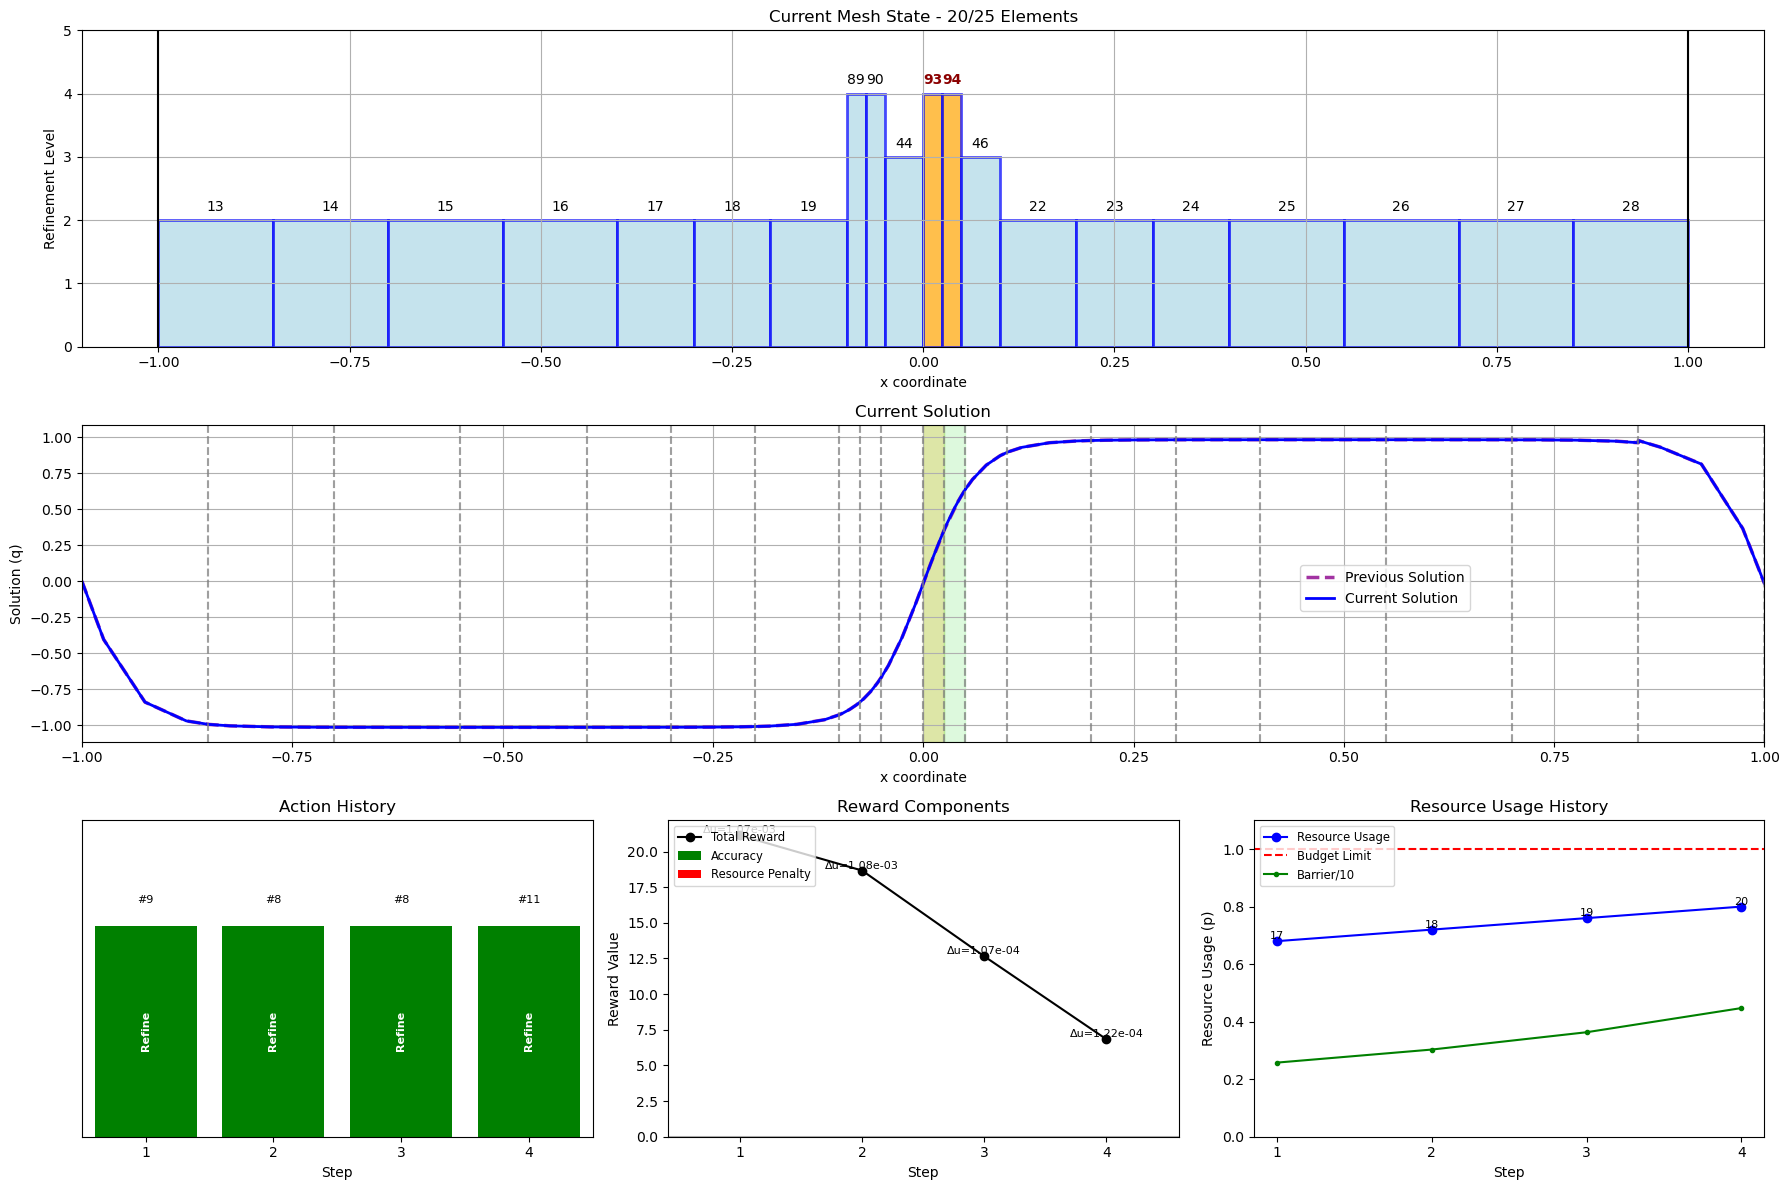

In [3]:
"""
Cell 3: Create and Launch Interactive Tester
Instantiate the tester with desired parameters and display the interface.
"""
tester = InteractiveAMRTester(
    nop=4,                                            # Polynomial order
    initial_elements=np.array([-1, -0.5, 0, 0.5, 1]), # Initial mesh boundaries
    max_level=4,                                      # Max refinement level
    element_budget=25,                                # Max allowed elements
    gamma_c=25.0,                                     # Resource penalty scaling
    machine_eps=1e-16,                                # Numerical stability constant
    initial_refinement_level=2,                       # Starting refinement
    accuracy_scaling=1.0,                             # Accuracy term scaling
    icase=10                                          # Test case (10 = tanh smooth square)
)
tester.show_tester()

In [ ]:
"""
Cell 4: Manual SVG Save (Optional)
Use this if the Save SVG button doesn't capture the plot correctly.
"""
# Save the current figure manually
if hasattr(tester, 'current_fig') and tester.current_fig is not None:
    tester.current_fig.savefig('amr_manual_save.svg', format='svg', bbox_inches='tight')
    print("Saved as amr_manual_save.svg")
else:
    print("No figure available. Run an action first.")

Saved current plot as SVG!


<Figure size 640x480 with 0 Axes>